In [140]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [141]:
pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [178]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
import pprint
import seaborn as sn
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [326]:
def drop_unwanted_columns(df):
    # for col in df.columns:
    #     if col.startswith('mid'):
    #         df = df.drop(col, axis=1)
    df = df.drop('team_id', axis=1)
    # df = df.drop('end_inhibKills', axis=1)
    # df = df.drop('end_championsKills', axis=1)
    # df = df.drop('end_towerKills', axis=1)
    # df = df.drop('end_assists', axis=1)
    # df = df.drop('end_deaths', axis=1)
    # df = df.drop('end_baronKills', axis=1)
    # df = df.drop('end_dragonKills', axis=1)
    # df = df.drop('end_totalDamage', axis=1)
    # df = df.drop('end_totalGold', axis=1)
    df = df.drop('game_time', axis=1)
    df = df.drop('game_id', axis=1)
    return df

In [327]:

with open('esports-data/lck_2023_average_stats.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)
df = drop_unwanted_columns(df)


df

,end_assists,end_baronKills,end_championsKills,end_deaths,end_dragonKills,end_inhibKills,end_totalDamage,end_totalGold,end_totalLevel,end_towerKills,...,mid_baronKills,mid_championsKills,mid_deaths,mid_dragonKills,mid_inhibKills,mid_totalDamage,mid_totalGold,mid_totalLevel,mid_towerKills,won
0,0.702059,0,0.438787,0.043879,3,0,1515.004193,1686.871575,2.457205,2,...,0,0.175515,0.000000,1,0,607.169291,882.926590,1.711268,0,True
1,0.087757,0,0.043879,0.438787,0,0,920.380484,1349.093576,2.281691,1,...,0,0.000000,0.175515,0,0,384.844582,721.321450,1.623511,0,False
2,0.721178,1,0.277376,0.305114,2,0,1797.087877,1628.696208,2.052582,7,...,0,0.110950,0.110950,0,0,655.092902,843.111992,1.414617,1,True
3,0.665702,0,0.305114,0.277376,3,0,1912.062034,1574.940746,2.024845,4,...,0,0.110950,0.110950,2,0,787.526755,856.120925,1.442355,2,False
4,0.261324,0,0.186660,0.485316,0,0,1137.277129,1497.796480,2.277251,3,...,0,0.111996,0.149328,0,0,436.468517,835.340446,1.642607,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,0.072784,1,0.048523,0.169829,2,0,1259.028362,1488.480122,1.965166,3,...,0,0.000000,0.072784,2,0,550.984976,788.711049,1.382895,1,False
466,0.495691,0,0.266911,0.571951,1,0,1058.385931,1575.839767,2.325935,2,...,0,0.038130,0.152520,0,0,387.306279,815.907359,1.639593,0,False
467,1.182032,1,0.571951,0.266911,2,0,1909.040234,1755.089253,2.554715,5,...,0,0.152520,0.038130,1,0,663.684007,831.006869,1.639593,0,True
468,0.233513,0,0.166795,0.300232,0,0,875.346099,1568.909804,2.201698,2,...,0,0.133436,0.200154,0,0,544.731291,883.648058,1.534517,1,False


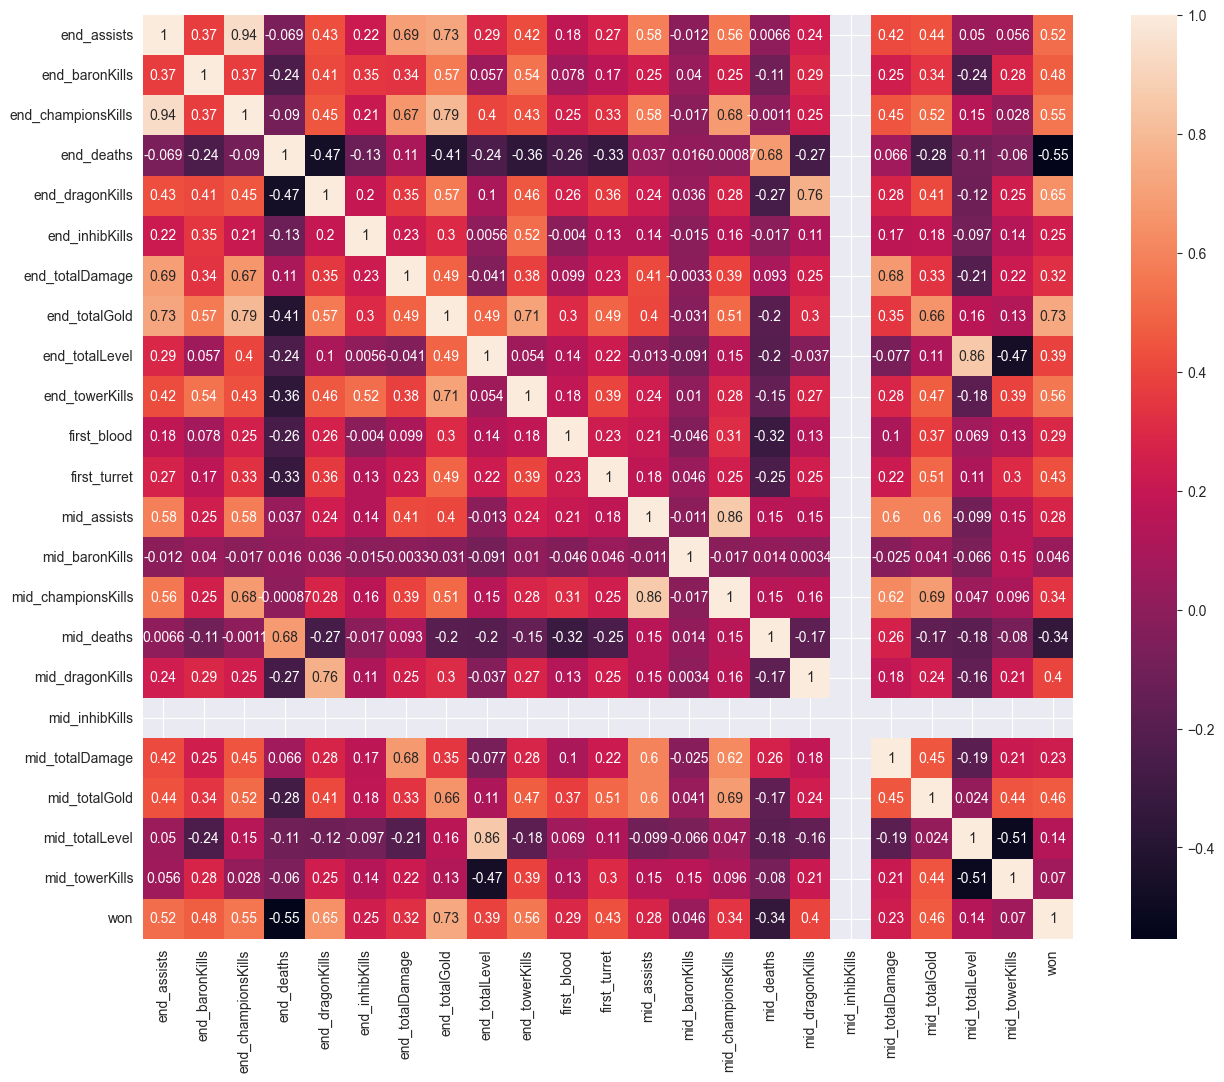

In [336]:
plt.figure(figsize=(15, 12))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [329]:
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = df.drop('won', axis=1), df[['won']]
# y = OrdinalEncoder().fit_transform(y)

In [330]:
y

,won
0,True
1,False
2,True
3,False
4,False
...,...
465,False
466,False
467,True
468,False


In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [332]:
# Create regression matrices
dtrain_clf = xgb.DMatrix(X_train, y_train)
dtest_clf = xgb.DMatrix(X_test, y_test)

In [333]:
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]


xgb_classifier = xgb.XGBClassifier(n_estimators=500, objective='binary:logistic', tree_method='hist', eta=0.07, max_depth=3, evals=evals)
xgb_classifier.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True, early_stopping_rounds=50)

model = xgb_classifier.get_booster()


[0]	validation_0-logloss:0.64467	validation_1-logloss:0.65024
[1]	validation_0-logloss:0.60010	validation_1-logloss:0.60950
[2]	validation_0-logloss:0.56249	validation_1-logloss:0.57603
[3]	validation_0-logloss:0.52791	validation_1-logloss:0.54446
[4]	validation_0-logloss:0.49641	validation_1-logloss:0.51740
[5]	validation_0-logloss:0.46891	validation_1-logloss:0.49327
[6]	validation_0-logloss:0.44419	validation_1-logloss:0.47153
[7]	validation_0-logloss:0.42161	validation_1-logloss:0.45238
[8]	validation_0-logloss:0.40107	validation_1-logloss:0.43498
[9]	validation_0-logloss:0.38176	validation_1-logloss:0.42024
[10]	validation_0-logloss:0.36391	validation_1-logloss:0.40783
[11]	validation_0-logloss:0.34847	validation_1-logloss:0.39515
[12]	validation_0-logloss:0.33349	validation_1-logloss:0.38446
[13]	validation_0-logloss:0.31996	validation_1-logloss:0.37315
[14]	validation_0-logloss:0.30706	validation_1-logloss:0.36251
[15]	validation_0-logloss:0.29522	validation_1-logloss:0.35243
[1

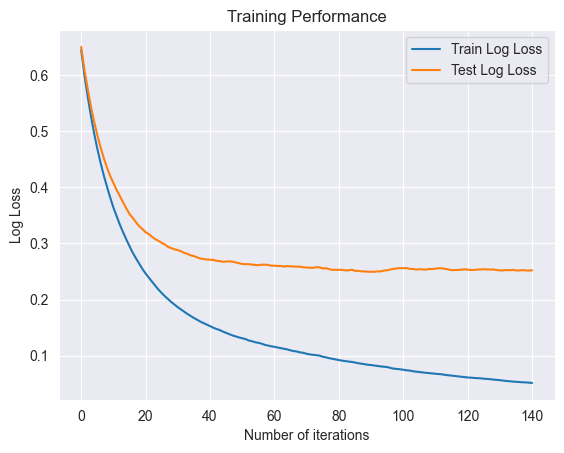

In [334]:
import matplotlib.pyplot as plt

results = xgb_classifier.evals_result()

train_error = results['validation_0']['logloss']
test_error = results['validation_1']['logloss']


x = range(len(test_error))
plt.plot(x, train_error, label='Train Log Loss')
plt.plot(x, test_error, label='Test Log Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Log Loss')
plt.title('Training Performance')
plt.legend()
plt.show()

In [306]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_clf)

In [295]:
rmse = mean_squared_error(y_test, preds, squared=False)

In [296]:
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.121


In [236]:
# with open('esports-data/lck_2023_team_average_stats.json', 'r') as json_file:
#     testing_data = json.load(json_file)
#
# with open('esports-data/teams_but_better.json', 'r') as json_file:
#     team_names = json.load(json_file)
#
#
# result_dict = dict()
#
# for team_name, team_stats in testing_data.items():
#     count = 0
#     prediction = 0
#     for entry in team_stats:
#         test = pd.DataFrame([entry])
#         test = drop_unwanted_columns(test)
#         test = test.drop('won', axis = 1)
#         test_matrix = xgb.DMatrix(test)
#         prediction += model.predict(test_matrix)
#         count += 1
#     prediction /= count
#     result_dict[team_names[team_name]] = prediction
#

with open('esports-data/lck_2023_average_stats.json', 'r') as json_file:
    testing_data = json.load(json_file)

with open('esports-data/teams_but_better.json', 'r') as json_file:
    team_names = json.load(json_file)


result_dict = dict()

for stats in testing_data:
    test = pd.DataFrame([stats])
    test = drop_unwanted_columns(test)
    test = test.drop('won', axis = 1)
    test_matrix = xgb.DMatrix(test)
    prediction = model.predict(test_matrix)
    result_dict[stats["game_id"]] = prediction


In [237]:
pprint.pprint(sorted(result_dict.items(), key=lambda x:x[1], reverse=True))


[('ESPORTSTMNT01:3373049', array([0.9993772], dtype=float32)),
 ('ESPORTSTMNT02:3220450', array([0.9993772], dtype=float32)),
 ('ESPORTSTMNT03:3166925', array([0.99935955], dtype=float32)),
 ('ESPORTSTMNT01:3413370', array([0.99927], dtype=float32)),
 ('ESPORTSTMNT02:3219287', array([0.99922955], dtype=float32)),
 ('ESPORTSTMNT02:3220488', array([0.99922955], dtype=float32)),
 ('ESPORTSTMNT02:3220856', array([0.99921644], dtype=float32)),
 ('ESPORTSTMNT03:3199211', array([0.9992077], dtype=float32)),
 ('ESPORTSTMNT06:2823467', array([0.9992077], dtype=float32)),
 ('ESPORTSTMNT02:3217854', array([0.9991934], dtype=float32)),
 ('ESPORTSTMNT01:3385759', array([0.99915135], dtype=float32)),
 ('ESPORTSTMNT01:3386462', array([0.99915135], dtype=float32)),
 ('ESPORTSTMNT01:3387101', array([0.99915135], dtype=float32)),
 ('ESPORTSTMNT01:3408177', array([0.99915135], dtype=float32)),
 ('ESPORTSTMNT01:3410713', array([0.99915135], dtype=float32)),
 ('ESPORTSTMNT01:3415182', array([0.99915135], d